<a href="https://colab.research.google.com/github/LK2705/sales-eda-project/blob/main/Logistic_Regression_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('/content/Sales_April_2019.csv')

# Data cleaning
# Remove empty rows
df = df.dropna()
df = df[df['Order ID'] != 'Order ID']  # Remove header rows that got mixed in

# Convert data types
df['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'], errors='coerce')
df['Price Each'] = pd.to_numeric(df['Price Each'], errors='coerce')
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%y %H:%M', errors='coerce')

# Remove rows with missing values
df = df.dropna()

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nColumns:", df.columns.tolist())

Dataset shape: (18289, 6)

First few rows:
  Order ID                     Product  Quantity Ordered  Price Each  \
0   176558        USB-C Charging Cable                 2       11.95   
2   176559  Bose SoundSport Headphones                 1       99.99   
3   176560                Google Phone                 1      600.00   
4   176560            Wired Headphones                 1       11.99   
5   176561            Wired Headphones                 1       11.99   

           Order Date                      Purchase Address  
0 2019-04-19 08:46:00          917 1st St, Dallas, TX 75001  
2 2019-04-07 22:30:00     682 Chestnut St, Boston, MA 02215  
3 2019-04-12 14:38:00  669 Spruce St, Los Angeles, CA 90001  
4 2019-04-12 14:38:00  669 Spruce St, Los Angeles, CA 90001  
5 2019-04-30 09:27:00     333 8th St, Los Angeles, CA 90001  

Columns: ['Order ID', 'Product', 'Quantity Ordered', 'Price Each', 'Order Date', 'Purchase Address']


In [2]:
# Feature Engineering
# Create a binary target variable: 1 if product price is above median, 0 otherwise
median_price = df['Price Each'].median()
df['High_Value'] = (df['Price Each'] > median_price).astype(int)

# Extract features from the data
df['Hour'] = df['Order Date'].dt.hour
df['DayOfWeek'] = df['Order Date'].dt.dayofweek
df['Month'] = df['Order Date'].dt.month

# Extract city from purchase address
df['City'] = df['Purchase Address'].str.split(',').str[1].str.strip()

# Create additional features
df['Total_Value'] = df['Quantity Ordered'] * df['Price Each']

print(f"Median price: ${median_price:.2f}")
print(f"High value items: {df['High_Value'].sum()} out of {len(df)}")
print(f"Class distribution:\n{df['High_Value'].value_counts()}")

Median price: $14.95
High value items: 8067 out of 18289
Class distribution:
High_Value
0    10222
1     8067
Name: count, dtype: int64


In [3]:
# Select features for the model
categorical_features = ['Product', 'City']
numerical_features = ['Quantity Ordered', 'Hour', 'DayOfWeek', 'Month']

# Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare feature matrix and target variable
features = numerical_features + [col + '_encoded' for col in categorical_features]
X = df[features]
y = df['High_Value']

print(f"Features used: {features}")
print(f"Feature matrix shape: {X.shape}")

Features used: ['Quantity Ordered', 'Hour', 'DayOfWeek', 'Month', 'Product_encoded', 'City_encoded']
Feature matrix shape: (18289, 6)


In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7243

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      3067
           1       0.67      0.72      0.70      2420

    accuracy                           0.72      5487
   macro avg       0.72      0.72      0.72      5487
weighted avg       0.73      0.72      0.73      5487



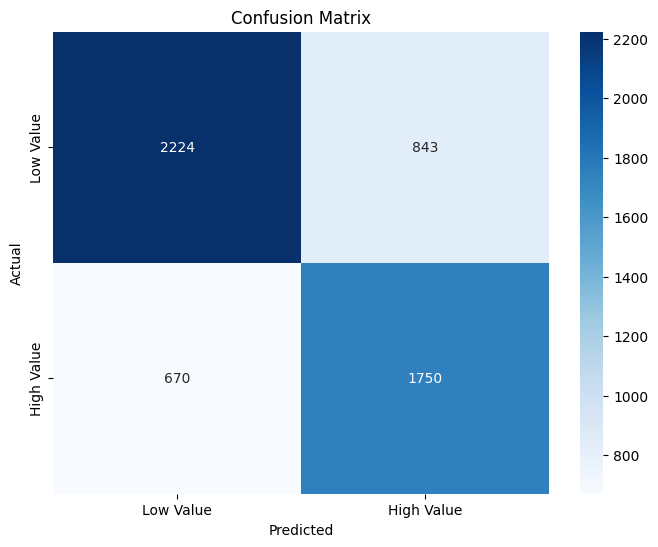


Feature Importance:
            feature  importance
0  Quantity Ordered    1.716867
4   Product_encoded    0.720592
3             Month    0.064533
2         DayOfWeek    0.040458
5      City_encoded    0.009393
1              Hour    0.009015

Model Coefficients:
            feature  coefficient
3             Month     0.064533
1              Hour     0.009015
5      City_encoded    -0.009393
2         DayOfWeek    -0.040458
4   Product_encoded    -0.720592
0  Quantity Ordered    -1.716867


In [5]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Value', 'High Value'],
            yticklabels=['Low Value', 'High Value'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': abs(logreg.coef_[0])
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Model coefficients
coefficients = pd.DataFrame({
    'feature': features,
    'coefficient': logreg.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\nModel Coefficients:")
print(coefficients)

In [6]:
# Product analysis
product_analysis = df.groupby('Product').agg({
    'Price Each': 'mean',
    'Quantity Ordered': 'sum',
    'High_Value': 'mean',
    'Order ID': 'count'
}).rename(columns={'Order ID': 'Count'}).sort_values('Price Each', ascending=False)

print("\nTop 10 Most Expensive Products:")
print(product_analysis.head(10))

print("\nTop 10 Most Frequently Ordered Products:")
print(product_analysis.sort_values('Count', ascending=False).head(10))

# City analysis
city_analysis = df.groupby('City').agg({
    'Price Each': 'mean',
    'High_Value': 'mean',
    'Total_Value': 'sum',
    'Order ID': 'count'
}).rename(columns={'Order ID': 'Count'}).sort_values('Total_Value', ascending=False)

print("\nCity-wise Sales Analysis:")
print(city_analysis)


Top 10 Most Expensive Products:
                        Price Each  Quantity Ordered  High_Value  Count
Product                                                                
Macbook Pro Laptop         1700.00               455         1.0    453
ThinkPad Laptop             999.99               392         1.0    392
iPhone                      700.00               695         1.0    693
LG Washing Machine          600.00                61         1.0     61
LG Dryer                    600.00                77         1.0     77
Google Phone                600.00               581         1.0    581
Vareebadd Phone             400.00               220         1.0    220
27in 4K Gaming Monitor      389.99               565         1.0    563
34in Ultrawide Monitor      379.99               653         1.0    650
Flatscreen TV               300.00               459         1.0    458

Top 10 Most Frequently Ordered Products:
                            Price Each  Quantity Ordered  Hig